    之前我们谈到了利用两只股票之间的相关系数进行配对交易，但我们能通过两只相关性较高的股票对之间的差价图看出，相关性高他们之间的价差并不一定会是一个平稳序列，简单来说我们无法利用这个不收敛的价差来进行套利。那么要进行真正统计意义上的套利得需要什么样的条件呢，那么就引出了我们的协整关系。首先谈协整我们得先知道平稳这一个概念，一个平稳序列是指数据的期望不会随时间改变，数据的方差与协方差不会随时间而改变，并且固定一个时间，往前与往后进行回归都是相同的。所以平稳的股票是有很多统计上的好性质，可以进行套利操作，当股价达到一定高度时就要卖出，当股价低于一定数值时就需要买入，也就是俗称的低买高卖。但是一般在现实生活中不存在平稳的股票，所以很难去预测他在什么地方是高点什么地方是低点，这也就解释了为什么这么多人都是买高卖低了。
    虽然一般不存在平稳的股票，但是几支股票的线性组合就可能是一个平稳序列，这就是我们一般意义上提到的协整关系，通过一些股票的组合来构造平稳的序列来进行套利。但是这个平稳性也是在一定时间段来说的，我们只能根据以往的数据来判断在这段时间内是协整的，但是无法断言在之后交易的时段也是协整的。

    我们来只管看一下一个平稳的序列长什么样，最简单的一个噪声序列他就是一个平稳的序列。

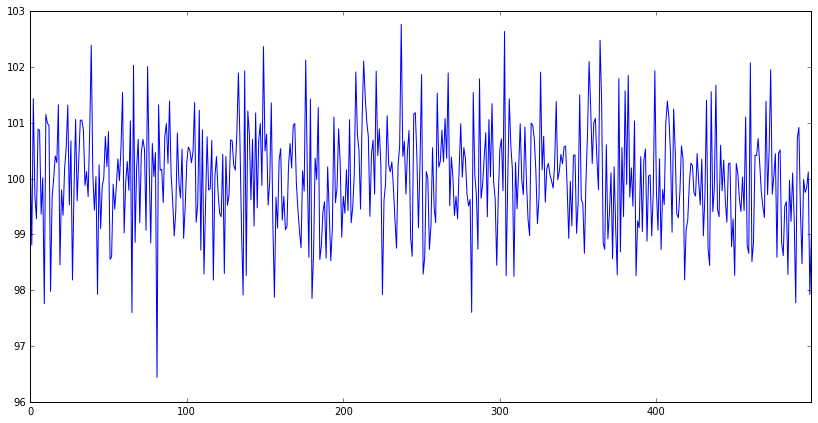

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

np.random.seed(1234)
x = np.random.normal(0, 1, 500)
X = pd.Series(x) + 100
X.plot(figsize=(14,7))

上图构建了一个以100为均值的噪声序列，可以看出这个序列的期望与方差协方差均不随时间而改变。我们来看看两个序列本身是非平稳的序列是怎么样的。

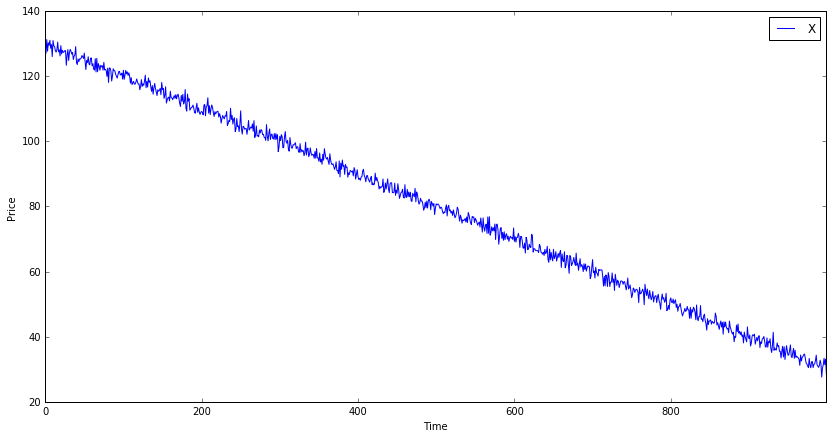

In [2]:
np.random.seed(1234)
x = np.random.normal(0, 1, 1000)
y = np.random.normal(0, 1, 1000)
X = pd.Series(x) + 100
Y = X + y + 30
for i in range(1000):
    X[i] = X[i] - i/10
    Y[i] = Y[i] - i/10
X.plot(figsize=(14,7));
plt.hold()
Y.plot(figsize=(14,7));
plt.xlabel("Time"); 
plt.ylabel("Price");
plt.legend(["X", "Y"]);

可以看出期望是随时间递减的，明显不是平稳序列，我们通过差分来看看是否能构造平稳序列。

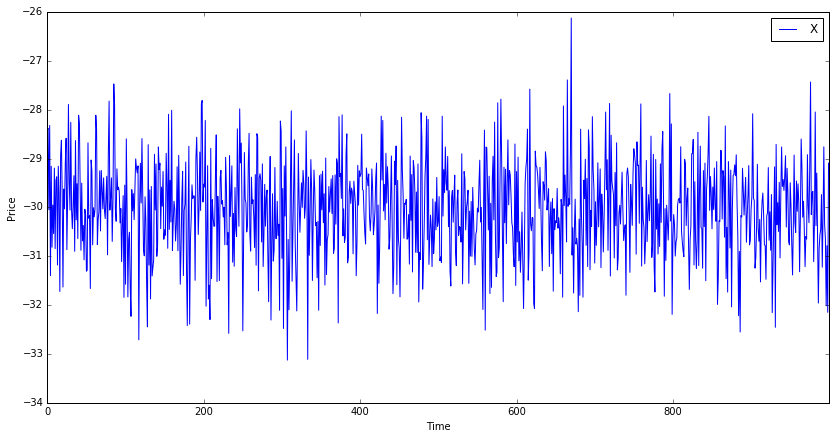

In [3]:
Z=X-Y
Z.plot(figsize=(14,7));
plt.xlabel("Time"); 
plt.ylabel("Price");
plt.legend(["X", "Y"]);

通过差分我们得到的就是一个跟噪声序列长的一样的平稳序列了。
那么一般股票序列是非平稳的我们怎么去找协整关系构建平稳的序列呢。

In [4]:
import statsmodels.api as sm
import seaborn as sns
def find_cointegrated_pairs(dataframe):
    # 得到DataFrame长度
    n = dataframe.shape[1]
    # 初始化p值矩阵
    pvalue_matrix = np.ones((n, n))
    # 抽取列的名称
    keys = dataframe.keys()
    # 初始化强协整组
    pairs = []
    # 对于每一个i
    for i in range(n):
        # 对于大于i的j
        for j in range(i+1, n):
            # 获取相应的两只股票的价格Series
            stock1 = dataframe[keys[i]]
            stock2 = dataframe[keys[j]]
            # 分析它们的协整关系
            result = sm.tsa.stattools.coint(stock1, stock2)
            # 取出并记录p值
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            # 如果p值小于0.05
            if pvalue < 0.05:
                # 记录股票对和相应的p值
                pairs.append((keys[i], keys[j], pvalue))
    # 返回结果
    return pvalue_matrix, pairs

[('601998.XSHG', '601988.XSHG', 0.028768046322897745), ('601998.XSHG', '601398.XSHG', 0.013629324146940534), ('601998.XSHG', '601939.XSHG', 0.016186699863228984), ('002142.XSHE', '601169.XSHG', 0.027812249267330186), ('002142.XSHE', '601818.XSHG', 0.0092541471307567586), ('002142.XSHE', '601398.XSHG', 0.0033907684560022452), ('002142.XSHE', '601939.XSHG', 0.033686497622529323), ('002142.XSHE', '600015.XSHG', 0.018079993954006082), ('600016.XSHG', '601288.XSHG', 0.001991599665954755), ('600016.XSHG', '601398.XSHG', 0.025213962807341925), ('600016.XSHG', '601939.XSHG', 0.00074291331294701216), ('601169.XSHG', '601818.XSHG', 0.0037269289212674877), ('601169.XSHG', '601398.XSHG', 0.0062386679292854314), ('000001.XSHE', '601818.XSHG', 0.026555557172914288), ('000001.XSHE', '601398.XSHG', 0.017055918585236828), ('601988.XSHG', '601288.XSHG', 0.049477774986942703), ('601988.XSHG', '601328.XSHG', 0.031518249690270679), ('601988.XSHG', '601398.XSHG', 0.0017579349683697794), ('601988.XSHG', '601

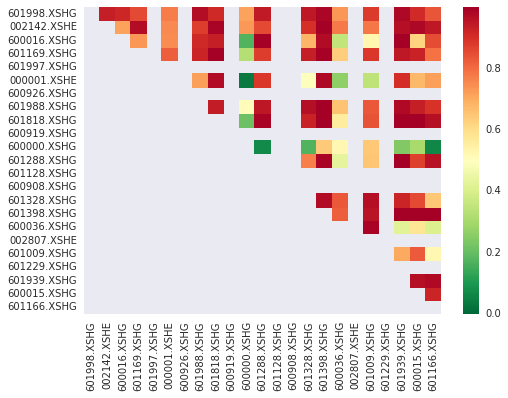

In [60]:
#选取所需要分析的板块，比如我们要看能源行业中具有协整关系的股票对，就为J66，可以更改为自己想研究的行业，选取网址在这https://www.ricequant.com/data/stock#Data—Stock-IndustrySectorConcept-industry
selected_plate=industry('J66')
stock_list = list(selected_plate)
#以14到15年时间的数据作为样本看这段时间的协整股票对。
prices_df = get_price(stock_list, start_date="2014-01-01", end_date="2015-12-01",adjust_type='internal')['ClosingPx']
#获得强协整性股票对
pvalues, pairs = find_cointegrated_pairs(prices_df)
#以热力图来形象表示
sns.heatmap(1-pvalues, xticklabels=stock_list, yticklabels=stock_list, cmap='RdYlGn_r', mask = (pvalues == 1))
#打印出强协整股票对
print (pairs)

从选出的股票里挑选p值最低的，也就是我们认为最符合协整关系的来看看他们之间的股价走势是怎么样的.

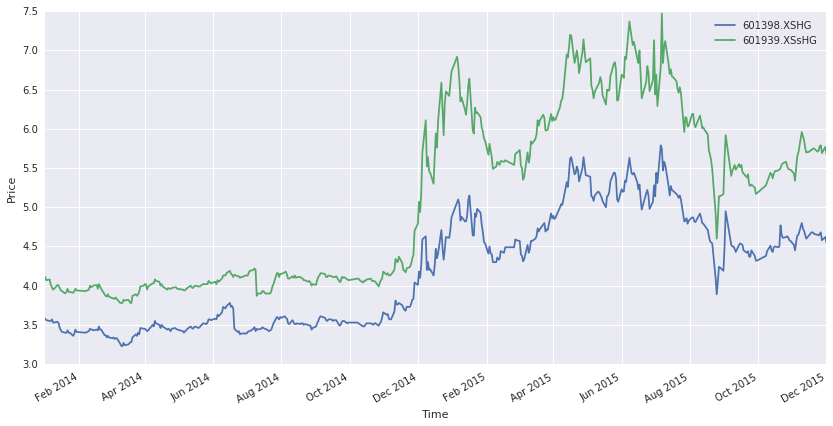

In [62]:
stock_sample1 = prices_df['601398.XSHG']
stock_sample2 = prices_df['601939.XSHG']
stock_sample1.plot(figsize=(14,7));
plt.hold()
stock_sample2.plot(figsize=(14,7));
plt.xlabel("Time"); 
plt.ylabel("Price");
plt.legend(['601398.XSHG', '601939.XSsHG']);

要利用这组股票对进行配对交易，就得看看他们之间的存在什么样的线性关系。这里我们通过股价进行最小残差平方和（OLS）方法来进行回归。

In [63]:
x = stock_sample1
y = stock_sample2
X = sm.add_constant(x)
result = (sm.OLS(y,X)).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            601939.XSHG   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 2.028e+04
Date:                Sun, 20 Nov 2016   Prob (F-statistic):               0.00
Time:                        06:56:26   Log-Likelihood:                 179.27
No. Observations:                 467   AIC:                            -354.5
Df Residuals:                     465   BIC:                            -346.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -1.2796      0.045    -28.141      

r-squred为0.978，说明我们拟合的参数解释了97.8%的样本数据，说明拟合结果比较好，AIC与BIC检验较小说明回归效果好，再来看看系数是否统计显著，const的系数的绝对值除标准误差std err明显大于自由度为465的t统计量，说明统计显著。至此，我们能认为我们回归得到的结果是比较好的了。

接下来我们看看线性组合的价差是否是在均值周围波动。

0.164835349769


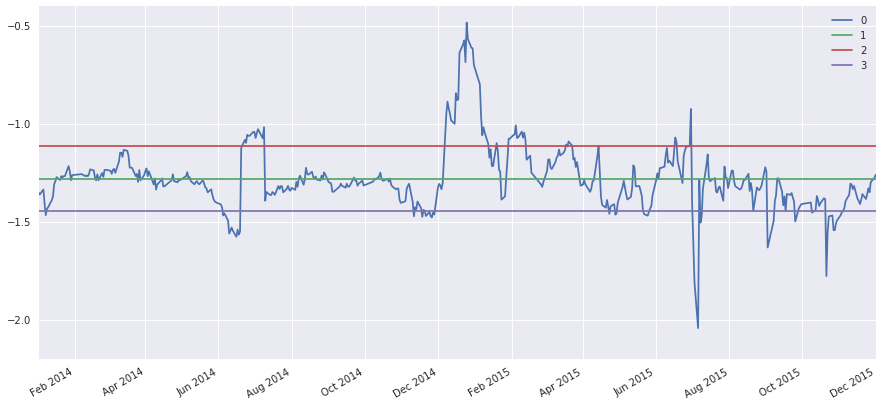

In [67]:
diff=y-1.5254*x
mean=np.mean(diff)
std=np.std(diff)
print(std)
up=mean+std
down=mean-std
time=diff.index
mean_line=pd.Series(mean,index=time)
up_line=pd.Series(up,index=time)
down_line=pd.Series(down,index=time)
set=pd.concat([diff,mean_line,up_line,down_line],axis=1)
set.plot(figsize=(15,7))

    至此，我们完成了配对交易的准备步骤，找到了协整股票对之间的线性关系以及股价差满足的模型，我们以'601818.XSHG'的股价减去拟合的系数0.6319倍'601988.XSHG'的股价，线性组合价差服从均值为0.9328标准误差为0.072的正态分布。根据这样的线性关系，我们构建这么一个简单的配对交易策略：组合价差超过均值+1倍标准误差即卖出601818，买入601988；低于均值1倍标准误差即买入601818，卖出601988.